# Adversarial examples for a DNN via Integer Linear Programming

_Combinatorial Optimization course, FEE CTU in Prague. Created by [Industrial Informatics Department](http://industrialinformatics.fel.cvut.cz)._

In this assigment you will learn that ILP can be used as a powerful tool for formal verification of complex systems. The application shown here concern of finding adverdarial examples that could fool a DNN trained with Tensorflow that perform handwritten digits recogtion.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as g
import scipy
%matplotlib inline

## MNIST dataset

Let us download MNIST dataset - a favourite benchmark for handwritten digit recognition.

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Lets see how our the data look like:

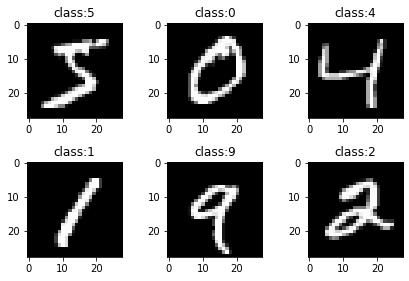

In [4]:
f, axarr = plt.subplots(2, 3)
plt.gray()
axarr[0, 0].imshow(x_train[0, :])
axarr[0, 0].set_title('class:'+str(y_train[0]))
axarr[0, 1].imshow(x_train[1, :])
axarr[0, 1].set_title('class:'+str(y_train[1]))
axarr[0, 2].imshow(x_train[2, :])
axarr[0, 2].set_title('class:'+str(y_train[2]))
axarr[1, 0].imshow(x_train[3, :])
axarr[1, 0].set_title('class:'+str(y_train[3]))
axarr[1, 1].imshow(x_train[4, :])
axarr[1, 1].set_title('class:'+str(y_train[4]))
axarr[1, 2].imshow(x_train[5, :])
axarr[1, 2].set_title('class:'+str(y_train[5]))
f.tight_layout()
plt.show()

## Building a DNN

Now, we build a very simple DNN using Keras API for Tensorflow. We will use four dense connected layers. _You may adjust sizes of the hidden layers for your experiments._

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(48, activation='relu'),
  tf.keras.layers.Dense(27, activation='relu'),
  tf.keras.layers.Dense(10)
])

This the ReLU activation function $f_{\boldsymbol{w}, b}(\boldsymbol{x}) = \max \{\boldsymbol{w}^T\boldsymbol{x} + b, 0\}$

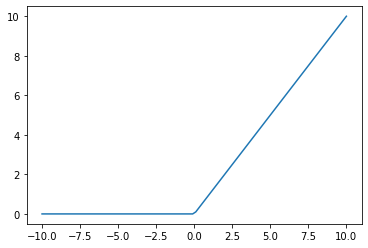

In [41]:
x = np.linspace(-10, 10, 100)
plt.plot(x, list(map(lambda t: max(t, 0), x)))

So we are using a dense fully connected network with ReLU activations. Next, we apply a standard loss function for multi-label classication.

In [6]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

And next, we train the network. Notice that this is an optimization problem as well - optimizing the given loss function over the train set.

In [7]:
model.fit(x_train, y_train, epochs=5)
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 32us/sample - loss: 0.3253 - accuracy: 0.9070
Epoch 2/5
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1527 - accuracy: 0.9554
Epoch 3/5
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1142 - accuracy: 0.9660
Epoch 4/5
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0938 - accuracy: 0.9717
Epoch 5/5
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0775 - accuracy: 0.9756


Lets see how the training went:

In [8]:
model.evaluate(x_test,  y_test, verbose=2)

10000/10000 - 0s - loss: 0.1082 - accuracy: 0.9698


[0.10822109760139137, 0.9698]

If you see accuracy above 0.9, then the training went well and we likely did not overfit the training set.

## Looking at the trained model

Next, we would like to test wheter the trained model works and intended. Lets ask our model on few inputs as a sanity check:

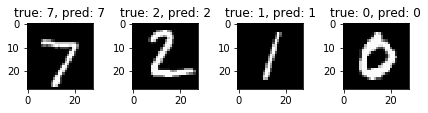

In [11]:
preds = probability_model(x_test[0:4])
f, axarr = plt.subplots(ncols=4)
plt.gray()
for k in range(4):
    axarr[k].imshow(x_test[k, :])
    axarr[k].set_title('true: {}, pred: {}'.format(y_test[k], max(range(10), key=lambda idx: preds[k][idx])))
f.tight_layout()
plt.show()

Now it comes to the interesting part. Is our DNN model foolproof? To find out that, we would like to have something like an "inverse" function to the network - which would map output to the input. However, this is not provided by the trained model.

Interestingly, we will show that such inverse can be realized with an ILP model. First, we will construct an ILP model that can be used for inference task - mapping inputs to outputs using the trained weights. Later on, we will use it for as the inverse function of the trained model.

In [12]:
weights = model.get_weights()

Lets explore the structure of your weight matrix:

In [13]:
len(weights)
print(weights[0].shape)
print(weights[1].shape)
print(weights[2].shape)
print(weights[3].shape)
print(weights[4].shape)
print(weights[5].shape)

(784, 48)
(48,)
(48, 27)
(27,)
(27, 10)
(10,)


We see that the structure contains always a matrix of weights coefficient and a vector of biases for each layer.

In [14]:
W = [weights[0], weights[2], weights[4]]
b = [weights[1], weights[3], weights[5]] 

## ILP to perform the inference given the trained weights

Now, we will construct an ILP model that is able to perform the inference in the network with the given trained weights $W$ and biases $b$.

We use a variable $f_{k,i}$ that denotes the output of $i$-th neuron in layer $k$ and $y_{k, i}$ which denotes the input signal of the corresponding neuron. $x$ variables serve as the input of the network.

In [24]:
ilp_model = g.Model()
x = ilp_model.addVars(W[0].shape[0], vtype=g.GRB.CONTINUOUS, lb=0, ub=1)
f = {}
y = {}
for k in range(3):
    for i in range(W[k].shape[0]):
        f[k, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=0)
        y[k, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=-float('inf'))
for i in range(W[2].shape[1]):
        f[3, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=0)
        y[3, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=-float('inf'))

Now, we need to establish proper constraints according to the structure of the network:

In [25]:
for i in range(W[0].shape[0]):
    ilp_model.addConstr(x[i] == f[0, i])
for k in range(1,4):
    for i in range(W[k-1].shape[1]):
        ilp_model.addConstr(g.quicksum(W[k-1][j, i]*f[k-1, j] for j in range(W[k-1].shape[0])) + b[k-1][i] == y[k, i])
        ilp_model.addConstr(f[k, i] == g.max_(y[k, i], 0))

Now let us note a small remark. Here we have used $\max$ in the constraints, which __is not a linear operation!__ We could linearize it and convert it back to a proper ILP model, but for sake of clarity let us keep like it is. Luckily, Gurobi can handle this one on its own. But please, do not use this construct in different solvers or your theoretical tests! This is not a feature of ILP but this particular solver.

## Inference DNN / ILP

Lets try the inference task using our ILP model. Consider, e.g., the following input:

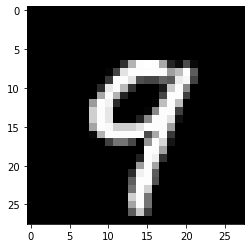

In [26]:
test_idx = 12
plt.gray()
plt.imshow(x_test[test_idx, :])

And let us use the trained DNN to classify it:

In [27]:
prediction = probability_model(x_test[test_idx:test_idx+1])
print('classified by the trained DNN as {} with probability p={}'.format(
        max(range(10), key=lambda idx: prediction[0][idx]), max(prediction[0]))
    )

classified by the trained DNN as 9 with probability p=0.999849796295166


Ok, now lets do the same with our implementation of DNN as an ILP model. We "feed" the input to the network by imposing equality constaints on our $x_i$ variables:

In [28]:
x_input_flatten = x_test[test_idx, :].reshape(1, 28*28)
for i in range(W[0].shape[0]):
    ilp_model.addConstr(x[i] == x_input_flatten[0][i])
    
ilp_model.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 1653 rows, 2522 columns and 41635 nonzeros
Model fingerprint: 0x6bc3f136
Model has 85 general constraints
Variable types: 2522 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 1e+00]
Presolve removed 1653 rows and 2522 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


Lets see the activations of the output layer and, as a sanity check, the softmax over the output:

In [30]:
result = [f[3, i].x for i in range(10)]
probs = np.exp(result)/sum(np.exp(result))
print('activations: ', result)
print('probabilities: ', probs)
pred_class_by_dnn = max(range(10), key=lambda idx: result[idx])
print('classified by ILP as {} with probability p={}'.format(
        pred_class_by_dnn, max(prediction[0]))
    )

activations:  [0.0, 0.0, 0.0, 0.0, 0.1955208638335597, 0.0, 0.0, 0.709117566861935, 0.0, 10.323768245760787]
probabilities:  [3.28320702e-05 3.28320702e-05 3.28320702e-05 3.28320702e-05
 3.99219641e-05 3.28320702e-05 3.28320702e-05 6.67212408e-05
 3.28320702e-05 9.99663532e-01]
classified by ILP as 9 with probability p=0.999849796295166


## Fooling the network - find a small perturbation of the input data by ILP

The model seems to work as intended. Now is the time to use ILP model as an inverse function of the model. We try to fool the network and find a small deviation of the input that will make the network to do a mistake. 

Let us find the smallest deviaton of a sample from the test set, that will cause the network to give incorrect classification on that sample:

In [31]:
ilp_model = g.Model()
x = ilp_model.addVars(W[0].shape[0], vtype=g.GRB.CONTINUOUS, lb=0, ub=1)
delta = ilp_model.addVars(W[0].shape[0], vtype=g.GRB.CONTINUOUS, lb=-1, ub=1)  # our vector of deviations
input_diff = ilp_model.addVars(W[0].shape[0], vtype=g.GRB.CONTINUOUS, lb=-1, ub=1)   
max_activation = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=0)
f = {}
y = {}
for k in range(3):
    for i in range(W[k].shape[0]):
        f[k, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=0)
        y[k, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=-float('inf'))
for i in range(W[2].shape[1]):
        f[3, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=0)
        y[3, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=-float('inf'))
for i in range(W[0].shape[0]):
    ilp_model.addConstr(x[i] + delta[i] == f[0, i])
    ilp_model.addConstr(delta[i] <= input_diff[i])
    ilp_model.addConstr(-delta[i] <= input_diff[i])

# these constrains just ensure that the information is propagated with the given weights thru the network   
for k in range(1,4):
    for i in range(W[k-1].shape[1]):
        ilp_model.addConstr(g.quicksum(W[k-1][j, i]*f[k-1, j] for j in range(W[k-1].shape[0])) + b[k-1][i] == y[k, i])
        ilp_model.addConstr(f[k, i] == g.max_(y[k, i], 0))   # beware! this is not an ILP constraint. but can be translated into a one
        
x_input_flatten = x_test[test_idx, :].reshape(1, 28*28)
for i in range(W[0].shape[0]):
    ilp_model.addConstr(x[i] == x_input_flatten[0][i])

    
# force the incorrect classification by saing that the maximal-activation output cannot the one that is correct
ilp_model.addConstr(max_activation == g.max_(f[3, k] for k in range(10)))
ilp_model.addConstr(f[3, pred_class_by_dnn] <= 0.95*max_activation)


ilp_model.setObjective(g.quicksum(input_diff[i] for i in range(W[0].shape[0])), sense=g.GRB.MINIMIZE)
ilp_model.params.timelimit = 90
ilp_model.optimize()

Changed value of parameter timelimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 3222 rows, 4091 columns and 45557 nonzeros
Model fingerprint: 0xf0728966
Model has 86 general constraints
Variable types: 4091 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 1e+00]
Presolve removed 2438 rows and 2645 columns
Presolve time: 0.07s
Presolved: 784 rows, 1446 columns, 40784 nonzeros
Presolved model has 15 SOS constraint(s)
Variable types: 1101 continuous, 345 integer (345 binary)

Root relaxation: objective 0.000000e+00, 597 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   24          -    0.00000      -     -    0s

Let us see, which adjustments of input are claimed to alter the prediction of the trained DNN:

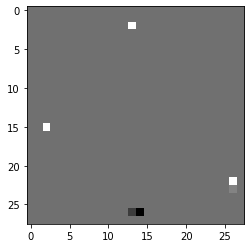

In [33]:
x_representation = np.array([delta[i].x for i in range(28*28)]).reshape(28, 28)
plt.gray()
plt.imshow(x_representation)

This is quite suprising result! Only a few pixels are changed and the network is fooled. Let us test it if it indeed the case:

classified by the trained DNN as 4 with probability p=0.5555132031440735


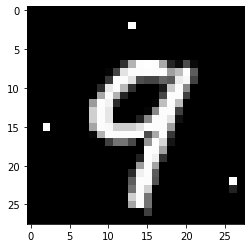

In [34]:
x_fooled_sample = np.add(x_test[test_idx:test_idx+1], x_representation)  # add the generated noise to the test example
plt.gray()
plt.imshow(x_fooled_sample[0])

prediction = probability_model(x_fooled_sample)
print('classified by the trained DNN as {} with probability p={}'.format(
        max(range(10), key=lambda idx: prediction[0][idx]), max(prediction[0]))
    )

Indeed it is true! The network was fooled, but it says its confidence of the output is not that high.

## Fooling the network even more!

So we can even more sophisticated attack - how about maximizing the probability of the wrong class given that only a few pixels deviate? In this case would be the network fooled such that it would think it is actually correct.

In [35]:
ilp_model = g.Model()
x = ilp_model.addVars(W[0].shape[0], vtype=g.GRB.CONTINUOUS, lb=0, ub=1)
delta = ilp_model.addVars(W[0].shape[0], vtype=g.GRB.CONTINUOUS, lb=-1, ub=1)
input_diff = ilp_model.addVars(W[0].shape[0], vtype=g.GRB.CONTINUOUS, lb=-1, ub=1)
max_activation = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=0)
f = {}
y = {}
for k in range(3):
    for i in range(W[k].shape[0]):
        f[k, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=0)
        y[k, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=-float('inf'))
for i in range(W[2].shape[1]):
        f[3, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=0)
        y[3, i] = ilp_model.addVar(vtype=g.GRB.CONTINUOUS, lb=-float('inf'))
for i in range(W[0].shape[0]):
    ilp_model.addConstr(x[i] + delta[i] == f[0, i])
    ilp_model.addConstr(delta[i] <= input_diff[i])
    ilp_model.addConstr(-delta[i] <= input_diff[i])
for k in range(1,4):
    for i in range(W[k-1].shape[1]):
        ilp_model.addConstr(g.quicksum(W[k-1][j, i]*f[k-1, j] for j in range(W[k-1].shape[0])) + b[k-1][i] == y[k, i])
        ilp_model.addConstr(f[k, i] == g.max_(y[k, i], 0))
        
x_input_flatten = x_test[test_idx, :].reshape(1, 28*28)
for i in range(W[0].shape[0]):
    ilp_model.addConstr(x[i] == x_input_flatten[0][i])

    
ilp_model.addConstr(max_activation == g.max_(f[3, k] for k in range(10)))
ilp_model.addConstr(f[3, pred_class_by_dnn] <= 0.95*max_activation)
ilp_model.addConstr(g.quicksum(input_diff[i] for i in range(W[0].shape[0])) <= 6)   # at most 6 pixels (in the sum of intensities) are deviated
 

ilp_model.setObjective(f[3, 7], sense=g.GRB.MAXIMIZE)
ilp_model.params.timelimit = 120
ilp_model.optimize()

Changed value of parameter timelimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 3223 rows, 4091 columns and 46341 nonzeros
Model fingerprint: 0x615ddbc7
Model has 86 general constraints
Variable types: 4091 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 6e+00]
Presolve removed 2568 rows and 2710 columns
Presolve time: 0.07s
Presolved: 655 rows, 1381 columns, 41308 nonzeros
Presolved model has 80 SOS constraint(s)
Variable types: 1101 continuous, 280 integer (280 binary)

Root relaxation: unbounded, 1009 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  postponed    0               -          -      -     -    0s
     0    

classified by trained DNN as 7 with probability p=0.9950284361839294


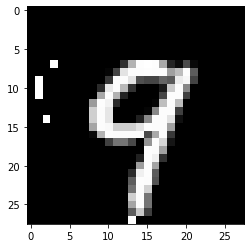

In [36]:
x_representation = np.array([delta[i].x for i in range(28*28)]).reshape(28, 28)
x_fooled_sample = np.add(x_test[test_idx:test_idx+1], x_representation)
plt.gray()
plt.imshow(x_fooled_sample[0])

prediction = probability_model(x_fooled_sample)
print('classified by trained DNN as {} with probability p={}'.format(
        max(range(10), key=lambda idx: prediction[0][idx]), max(prediction[0]))
    )

Quite interesting as well - only these few pixels have fooled the trained DNN which thinks it gives good results with high confidence. This demonstrate that solution of many ML model might be very fragile, if they are not trained sofistically. Moreover, this lab assignment has demonstrated the power of ILP as a tool for the formal verification of complex systems.

## More ideas for you to play with
* How would you adjust the constraints to make the adversarial noise less visible to a naked eye?
* We have generated the adversarial noise for a specific example in the test set. Try to apply it to other. Is the network still fooled? Can you generate a noise that would be applicable to more examples at once?
* Can you find what is the most "ideal" representation of number 8 according to the trained network? Does the result suprises you? What does it say about the network? 
* Are so-called "shallow" models susceptible as well (e.g., decision trees/random forests - you might test with ILP as well)? 
* Which other "systems" could be analyzed with ILP?
* How could you use ILP for training (finding good parameter values) robust networks? How large networks could you  realistically  train with the current technology?
* What is the relation between the number of network parameters and robustness of the network. Does the drop-out improve the resistence to such attacks?
* How would you validate the performance of a ML model better rather than the accuracy on the test set?